***
**Algorithmes d'optimisation -- L3 DD 2020/2021 -- Université Paris-Saclay**
***

# TP 4 : Projection sur le simplexe et optimisation de portefeuille


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
%matplotlib inline
# la commande suivante agrandit les figures
plt.rcParams['figure.figsize'] = [9.,6.]

def verifier_gradient(f,g,x0):
    N = len(x0)
    gg = np.zeros(N)
    for i in range(N):
        eps = 1e-4
        e = np.zeros(N)
        e[i] = eps
        gg[i] = (f(x0+e) - f(x0-e))/(2*eps)
    print('erreur numerique dans le calcul du gradient: %g (doit etre petit)' % np.linalg.norm(g(x0)-gg))

## I. Projection sur le simplexe
$\newcommand{\Rsp}{\mathbb{R}}$
$\newcommand{\sca}[2]{\langle #1|#2\rangle}$
$\newcommand{\eps}{\varepsilon}$
$\newcommand{\proj}{\mathrm{proj}}$
Comme dans le troisième exercice de la feuille de TD consacrée au calcul de projections, on appelle simplexe l'ensemble 

$$\Delta = \{ x\in \Rsp_+^n \mid \sum_{1\leq i \leq n} x_i = 1\}.$$

Dans un premier temps, on va chercher à calculer la projection d'un point 
$y\in\Rsp^n$ sur $\Delta$. Pour cela, on admettra les deux résultats suivants, démontrés dans le TD:

- il existe $\kappa\in\Rsp$ tel que $\sum_{1\leq i\leq n} \max(y_i - \kappa, 0) = 1$
- la projection de $y$ sur $\Delta$ s'écrit alors $\proj_\Delta(y) = (\max(y_i - \kappa, 0))_{1\leq i\leq n}$

Ainsi, pour trouver la projection d'un point $y\in\Rsp^n$ sur le simplexe $\Delta$, il suffit de trouver $\kappa\in\Rsp$ tel que $g(\kappa) = 0$ où l'on a posé
$$ g(\kappa) = \left(\sum_{1\leq i\leq n} \max(y_i - \kappa, 0)\right) -1$$


**Q1)** Soit $y = (0.1,1.5,2.1) \in \Rsp^3$. Écrire la fonction `g(kappa)` décrite ci-dessus. Trouver $\kappa$ vérifiant $g(\kappa) = 1$ en utilisant la fonction `scipy.optimize.root(g,x0=0,method='anderson').x`.

In [6]:
y = np.array([0.1,1.5,2.1])
def g(k):
    return np.sum(np.maximum(y-k,0)) - 1.0

k = scipy.optimize.root(g,x0=0,method='anderson').x
print(k)


1.299997717450157


**Q2)** En s'inspirant du code de la fonction précédente, écrire une fonction proj_simplexe calculant la projection d'un point $y\in\Rsp^n$ sur $\Delta$. Pour vérifier le bon fonctionnement de cette fonction, calculer calculer $p=$`proj_simplexe(y)` pour $y=$`np.random.randn(n)` puis vérifier que 

$$ \forall i\in\{1,\dots,n\}, \sca{y - p}{p - e_i} \geq 0,$$

où $e_i$ est le $i$ème vecteur de la base canonique.

*(Question subsidiaire: pourquoi cette inégalité doit-elle être vraie pour $p = \proj_\Delta(y)$ ? Caractérise-t-elle la projection sur $\Delta$?)*
<!-- (dans le cas $n=2$, on peut également tirer quelques points aléatoirement dans le plan et visualiser le segment qui les relie à leur projection sur $\Delta$) -->

In [7]:
def proj_simplexe(y):
    g = lambda k: np.sum(np.maximum(y-k,0)) - 1.0
    sol = scipy.optimize.root(g,x0=0,method='anderson') # scipy.optimize.fsolve(g,0)
    k = sol.x
    return np.maximum(y-k,0)

# validation: calcul de produits scalaires
n = 10
y = np.random.randn(n)
p = proj_simplexe(y)
for i in range(n):
    ei = np.zeros(n)
    ei[i] = 1
    print(np.dot(y-p, p-ei))


1.542915795127442e-10
0.18619152132671468
0.26012877686525626
1.67252021264137
1.5500472836953236
1.542915795127442e-10
2.7120309761534784
0.5687525065252534
2.2842838661688853
1.146162192687245


## II. Optimisation de portefeuille.

Dans cette partie, il s'agit de résoudre un problème d'optimisation sous contraintes de la forme suivante:

$$ \min_{x\in\Delta} f(x) \hbox{ où } f(x) = \frac{1}{2}\sca{x}{Qx} + \frac{1}{2\eta}(\sca{r}{x}-r_0)^2, $$

où $Q \in \mathcal{M}_{n,n}(\Rsp)$ est une matrice symétrique définie positive, $r\in\Rsp$ est un vecteur et $r_0\in\Rsp$ sont donnés. Dans la suite, on fixera $\eta = 10^{-2}$. 

**Motivation:** Ce problème modélise une situation où un investisseur cherche placer un portefeuille en garantissant un certain niveau de rendement $r_0\in\Rsp$ tout en minimisant le risque. Plus précisément, dans ce problème $n$ est le nombre d'actifs (actions, etc.), et la variable $x\in\Rsp^n$ décrit la stratégie d'investissement: $x_i$ décrit la fraction du portefeuille que l'on investit dans l'actif $i$. Ainsi, la contrainte $x\in\Delta$ modélise:

- qu'on investit une fraction $x_i$ positive dans chaque actif (contrainte $x_i\geq 0$);
- et que la somme totale disponible est investie ($\sum_i x_i = 1$).

La matrice $Q$ modélise la covariance entre les actifs:
- si $Q_{ij}\geq 0$, cela signifie que les actifs financiers $i$ et $j$ sont positivement correlés, et il est donc risqué d'investir dans les deux en même temps. 
- au contraire, si $Q_{i,j}<0$, les actifs sont négativement correlés, et en investissant dans les deux on diminue le risque. 
Le problème d'optimisation qu'on regarde consiste donc à trouver une stratégie d'investissement ($x\in \Delta$) cherchant à viser un rendement donné (terme $\frac{1}{2\eta}(\sca{r}{x}-r_0)^2$) tout en minimisant le risque (terme $\sca{x}{Qx}$).

En pratique, on considèrera les données suivantes:

In [8]:
# Le code suivant permet de construire la matrice $Q$ à partir de données réelles.
# Ne pas hésiter à la décommenter et à tester avec d'autres choix d'actifs. Pour cela,
# il faut installer le package yfinance en lançant la ligne suivant
# !pip install yfinance
if False: # mettre True pour changer les dates, les actifs, etc
    import yfinance as yf 
    import numpy as np
    stocks = ['NFLX','MSFT','BA','AIR']
    closes = np.array([np.array(yf.download(s,'2019-01-01','2020-01-01').Close) for s in stocks]).T
    r = (closes[-1,:] - closes[1,:])/closes[1,:] # rendement sur l'année 2019
    Q = np.cov(closes - np.mean(closes,0),rowvar=False) # estimation de la covariance entre les valeurs

Q = np.array([[1199.6242199,  -225.74269344,  270.42617708, -112.31853678],
              [-225.74269344,  224.42514399, -157.75776414,   46.31290714],
              [ 270.42617708, -157.75776414,  600.37115079,  -28.1665365 ],
              [-112.31853678,   46.31290714,  -28.1665365,    21.77422792]])
r = np.array([0.20888442, 0.55953316, 0.00602209, 0.2042723])
r0 = 0.7*np.max(r)
eta = 1e-4

**Q1)** Montrer que la fonction $f$ est strictement convexe et que
$\nabla f(x) = Qx + \frac{1}{\eta} (\sca{r}{x}-r_0) r.$

## II.1. Méthode de gradient projeté

**Q2)** Écrire une fonction `f` et `gradf`, et utiliser la fonction `verifier_gradient` pour valider l'implémentation.

In [9]:
def f(x):
    return .5*np.dot(x,Q@x) + .5/eta*(np.dot(x,r) - r0)**2
def gradf(x):
    return Q@x + 1/eta*(np.dot(x,r)-r0)*r

# vérification du calcul du gradient
verifier_gradient(f,gradf,np.random.rand(len(r)))

erreur numerique dans le calcul du gradient: 6.88157e-10 (doit etre petit)


**Q3)** Implémenter l'algorithme du gradient projeté pour résoudre le problème avec les données ci-dessus, i.e.

$$ \begin{cases} x^{(0)} = 0_{\Rsp^n}\\
x^{(k+1)} = \mathrm{proj\_simplexe}(x - \tau \nabla f(x^{(k)})) 
\end{cases}$$ 

Tracer sur deux figures distinctes:
- La suite des valeurs $f(x^{(k)})$ pour $1\leq k<100$.
- La suite $\|{x^{k} - x^{(k-1)}}\|$ pour $1\leq k<100$ (on pourra mettre les abscisses en échelle logarithmique). Pourquoi la convergence de cette suite vers zéro est-elle une indication du bon fonctionnement de l'algorithme?

Pour choisir le paramètre $\tau$ de l'algorithme du gradient projeté, on pourra procéder par tâtonnement: par exemple, choisir $\tau$ de sorte à ce que $k\mapsto f(x^{(k)})$ soit décroissante et que la suite $\|{x^{k} - x^{(k-1)}}\|$ semble tendre vers zéro.

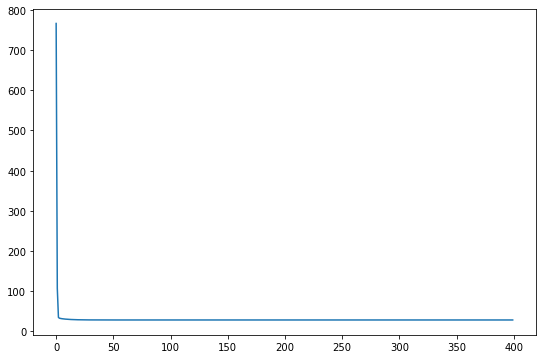

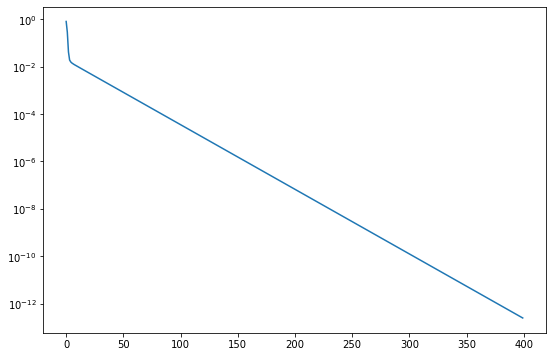

In [10]:
x = np.zeros(len(r))
tau = .0005
niter = 400
F = np.zeros(niter)
G = np.zeros(niter)
for i in range(niter):
    xnew = proj_simplexe(x - tau*gradf(x))
    G[i] = np.linalg.norm(x-xnew)
    F[i] = f(x)
    x = xnew
plt.plot(F)
plt.figure()
plt.semilogy(G)


## II.2. Méthode de pénalisation

**Q1** Montrer que le simplexe $\Delta = \{ x\in\Rsp_+^n\mid \sum_i x_i = 1\}$ peut-être mis sous la forme

$$ \Delta = \{ x\in\Rsp^n \mid \forall 1\leq i\leq \ell, c_i(x) \leq 0 \} $$

avec $\ell = n+2$ et 

$$ c_i(x) = \begin{cases} -x_i & \hbox{ si } 1\leq i\leq n \\
x_1+\dots+x_n - 1 & \hbox{ si } i=n+1\\
-(x_1+\dots+x_n - 1) & \hbox{ si } i=n+2\end{cases} $$

Dans la méthode de pénalisation, le problème d'optimisation sous contraintes 

$$ P =  \min_{x\in\Delta} f(x) \hbox{ où } f(x) = \frac{1}{2}\sca{x}{Qx} + \frac{1}{2\eta}(\sca{r}{x}-r_0)^2, $$

est alors approché par le problème d'optimisation sans contraintes suivant:

$$ P_\eps = \min_{x\in\Rsp^n} f_\eps(x) \hbox{ où } f_\eps(x) = f(x) + \frac{1}{\eps}\sum_{1\leq i\leq \ell} \max(c_i(x),0)^2 $$

**Q2** Montrer que 

$$ f_\eps(x) = f(x) + \frac{1}{\eps}\left(\sum_{1\leq i\leq n} \max(-x_i,0)^2)\right) + \frac{1}{\eps}(x_1+\dots+x_n - 1)^2 $$
$$(\nabla f_\eps(x))_i = (\nabla f(x))_i - \frac{2}{\eps} \max(-x_i,0) + \frac{2}{\eps} (x_1+\dots+x_n - 1)$$

Coder deux fonctions `feps(x)` et `gradfeps(x)`, et vérifier leur bon fonctionnement en utilisant `verifier_gradient`.

In [11]:
eps = 1e-3

def feps(x):
    return f(x) + 1/eps*(np.sum(np.maximum(-x,0)**2))+ 1/eps*(np.sum(x)-1)**2

def gradfeps(x):
    return gradf(x) - 2/eps*np.maximum(-x,0) + 2/eps*(np.sum(x)-1)

verifier_gradient(feps,gradfeps,10*(np.random.rand(len(r))-.5))

erreur numerique dans le calcul du gradient: 2.1441e-07 (doit etre petit)


**Q3** En utilisant la fonction `gradient_armijo` ci-dessous, vérifier le fonctionnement de cette approche pour des valeurs de `eps` modérées ($\eps = 10^{-2}$ où $10^{-3}$). Commenter les résultats (respect des contraintes, vitesse de convergence).

iteration 100: f=27.046144, |g|=0.845659, step=0.000488
iteration 200: f=27.043326, |g|=0.126056, step=0.000122
iteration 300: f=27.043311, |g|=0.009161, step=0.000122
iteration 400: f=27.043311, |g|=0.000666, step=0.000122
iteration 500: f=27.043311, |g|=0.000027, step=0.000244


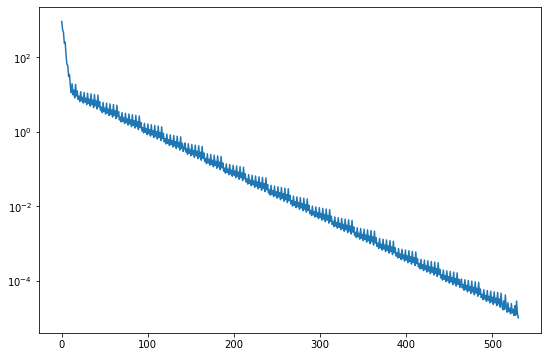

In [12]:
def gradient_armijo(f,gradf,x0,err=1e-5,maxiter=20000):
    x = x0.copy()
    fiter = []
    giter = []
    k = 0 # nombre d'itérations
    while(True): 
        k = k+1
        if k > maxiter: # maximum de 10^6 itérations
            print('erreur: nombre maximum d\'itérations atteint')
            break
        d = -gradf(x)
        fiter.append(f(x))
        giter.append(np.linalg.norm(d))
        if np.linalg.norm(d) <= err:
            break
        t = 1
        m = -np.dot(d,d)
        while f(x+t*d) > f(x) + 0.3*t*m:
            t = 0.5*t
        if k%100==0: # on affiche des informations toute les 100 itérations
            print('iteration %d: f=%f, |g|=%f, step=%f' % (k, f(x), np.linalg.norm(d),t))
        x = x + t*d
    return x,np.array(fiter),np.array(giter)

x0 = np.ones(len(r))/len(r)
x,fiter,giter = gradient_armijo(feps,gradfeps,x0,err=1e-5)
plt.semilogy(giter)


In [13]:
x

array([0.12850422, 0.48099324, 0.04045282, 0.36423464])

In [14]:
np.sum(x)

1.0141849154572289